In [79]:
""" file : reduce_utils.py """
""" helper functions for reduce.py main"""

from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import requests as req
import json
import pandas as pd
import math as math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm



""" general imports """
import sys
import string

""" imports for plots, dataframes, numpy """
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

""" keras neural network imports """
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

""" sklearn imports """
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def plot_series(time_points, original_series, encoded_time_points, encoded_series, window, series_name):
    """ plot the original time series vs predicted time series """
    plt.figure(figsize=(16, 6), dpi=120)
    plt.plot(time_points, original_series, color = 'red', label = 'Original Time Series Values')
    plt.plot(encoded_time_points, encoded_series, color = 'blue', label = 'Encoded Time Series Values')
    plt.xticks(np.arange(time_points[0], time_points[-1], window))
    plt.title("Time Series Prediction (name of series --> %s)" % (series_name))
    plt.xlabel('Time')
    plt.ylabel('Time Series Value')
    plt.legend()
    plt.show()

#plot_series([1,2,3,4,5,6], np.array([1,2,3,6,7,8]), [1,3,5], np.array([1,3,7]),2,'aaa')

In [80]:
# size of each timeseries is 3650 points and there are 360 timeseries

        

def plot_loss(history):
    """ plot the train loss vs test loss learning curve for given training history """
    plt.figure(figsize=(16, 6), dpi=120)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs test loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


def plot_series(time_points, original_series, encoded_time_points, encoded_series, window, series_name):
    """ plot the original time series vs predicted time series """
    fig, axs = plt.subplots(2)
    axs[0].plot(time_points, original_series, color = 'red', label = 'Original Time Series Values')
    axs[1].plot(encoded_time_points, encoded_series, color = 'blue', label = 'Encoded Time Series Values')
    fig.suptitle("Time Series Prediction (name of series --> %s)" % (series_name))
    fig.show()

def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")




def split_dataset(input_set, num_of_series, num_of_steps, w, series_to_use):
    """ split each time series in the input set in chanks of size w and use those to train the convolutional autoencoder 
        input_set : 2D array -> columns are different time series, rows are time series values across time
        num_of_series : number of series in input_set
        num_of_steps  : number of steps = size of x_set and y_set
        w : window of sampling 
        is_prediction : Boolean value to see if the split will be used to encode a timeseries. 
                        If the value is False, then the data will be used for the training of the model"""

    # x_set will contain windows of w consecutive values for all time series of input_set
    # It splits the input set to train sets of size w
    x_set = []

    if series_to_use is None:
        i_index_list = range(0,num_of_steps,w) # a prediction is desired so split the timeseries and encode it, don't use it to train the model
    else:
        i_index_list = range(0, num_of_steps-w+1)

    for series_index in range(num_of_series):
        for i in i_index_list:
            # append next window of w consecutive values of time series in x_set
            x_set.append(input_set[i:i+w, series_index])
    # convert to np arrays
    x_set = np.array(x_set)
    #print(x_set.shape)
    # reshape x_set to a tensor of size (#time_series * num_of_steps/window, window, 1)
    x_set = np.reshape(x_set, (x_set.shape[0], x_set.shape[1], 1))

    return x_set


def execute(series_values, series_names, w, load_trained_model, series_to_use, window_length, latent_dimension,epochs,max_encoded_lines_to_print):
    """ function where main work gets done
        series_values : 2D array -> columns are different time series, rows are time series values across time
        series_names  : 1D array -> rows have the names of the time series
        w : window of sampling
        load_trained_model : if True, a pre trained model will be loaded, otherwise a new model will be trained
        series_to_use   : if not None, training/loading is done per given series, otherwise per entire set of series """

    # train test split 80-20 rule (the first 80% of time series values will be used for the training, rest 20% for testing)
    train_set_size = math.floor((series_values.shape[0])*0.8)

    # save train set after split
    train_set = series_values[:train_set_size]

    # save test set after split
    test_set = series_values[train_set_size:]

    # scale train set manually using min max scaling
    scaled_train_set = (train_set - train_set.min()) / (train_set.max() - train_set.min())

    num_of_series = series_values.shape[1]

    # get x_train
    x_train = split_dataset(scaled_train_set, num_of_series, train_set.shape[0], w, series_to_use)

    if load_trained_model is False:
        """
        # configure new convolutional encoder and autoencoder models for series 
        input_window = Input(shape=(window_length,1))
        x = Conv1D(32, 3, activation="relu", padding="same")(input_window) # window_length dim
        #x = BatchNormalization()(x)
        x = MaxPooling1D(2, padding="same")(x) # window_length/2 dim
        x = Conv1D(16,3,activation="relu",padding="same")(x)
        x = Conv1D(1,3,activation='relu',padding='same')(x)
        #x = BatchNormalization()(x)
        x = Flatten()(x)
        encoded = Dense(latent_dimension, activation='relu',name='encoder')(x) # latent_dimension dim

        # Finished autoencoder
        y = Dense((window_length//2), activation='relu')(encoded)
        y = Reshape((window_length//2,1))(y)
        #x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
        #x = BatchNormalization()(x)
        #encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

        # latent_dimension dimensions in the encoded layer

        y = Conv1D(1, 3, activation="relu", padding="same")(y) # 3 dims
        #y = BatchNormalization()(y)
        y = Conv1D(16, 1, activation='relu')(y) # 5 dims
        y = UpSampling1D(2)(y) # 6 dims
        #y = Conv1D(16,1,activation='relu')(y)
        #y = BatchNormalization()(y)
        #x = UpSampling1D(2)(x) # 10 dims
        decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(y) # 10 dims
        model_autoencoder = Model(input_window, decoded)
        model_autoencoder.summary()
        model_autoencoder.compile(metrics=[tf.metrics.MeanAbsoluteError()],optimizer=tf.optimizers.Adam(), loss='mean_squared_error')
        """
        """
        input_window = Input(shape=(window_length,1))
        x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
        #x = BatchNormalization()(x)
        x = MaxPooling1D(2, padding="same")(x) # 5 dims
        x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
        #x = BatchNormalization()(x)
        encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

        # 3 dimensions in the encoded layer

        x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
        #x = BatchNormalization()(x)
        x = UpSampling1D(2)(x) # 6 dims
        x = Conv1D(16, 2, activation='relu')(x) # 5 dims
        #x = BatchNormalization()(x)
        x = UpSampling1D(2)(x) # 10 dims
        decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
        model_autoencoder = Model(input_window, decoded)
        model_autoencoder.summary()
        model_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        """
        
        input_window = Input(shape=(window_length,1))
        x = Conv1D(8, 3, activation="relu", padding="same")(input_window) # window_length dim
        #x = BatchNormalization()(x)
        x = MaxPooling1D(2, padding="same")(x) # window_length/2 dim
        x = Conv1D(2,3,activation='relu',padding='same')(x)
        #x = BatchNormalization()(x)
        x = Flatten()(x)
        encoded = Dense(latent_dimension, activation='relu',name='encoder')(x) # latent_dimension dim

        # Finished autoencoder
        y = Dense((window_length//2), activation='relu')(encoded)
        y = Reshape((window_length//2,1))(y)
        #x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
        #x = BatchNormalization()(x)
        #encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

        # latent_dimension dimensions in the encoded layer

        #y = Conv1D(8, 3, activation="relu", padding="same")(y) # 3 dims
        #y = BatchNormalization()(y)
        y = UpSampling1D(2)(y) # 6 dims
        #y = Conv1D(16,1,activation='relu')(y)
        #y = BatchNormalization()(y)
        #x = UpSampling1D(2)(x) # 10 dims
        decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(y) # 10 dims
        model_autoencoder = Model(input_window, decoded)
        model_autoencoder.summary()
        model_autoencoder.compile(metrics=['accuracy'],optimizer=tf.optimizers.Adam(), loss='binary_crossentropy')


    else:
        if series_to_use is not None:
            # load pre trained convolutional encoder and autoencoder model for series
            model_encoder = load_model('./content/models/reduce/model_' + str(series_to_use) + '.h5')
        else:
            # load pre trained convolutional encoder and autoencoder model for entire set of series
            model_encoder = load_model('./content/models/reduce/big_model.h5')


    # normalize with minmax normalization based on train set
    scaled_test_set = (test_set - test_set.min()) / (test_set.max() - test_set.min())

    # get x_test
    x_test = split_dataset(scaled_test_set, num_of_series, test_set.shape[0], w, series_to_use)

    # if load_trained_model option was not given, train new model
    if load_trained_model is False:
        # train model by fitting it to the training set
        history = model_autoencoder.fit(x_train, x_train, epochs =epochs, batch_size = 1024, validation_data=(x_test, x_test), verbose=1)
        model_encoder = Model(input_window, encoded)
        
        # plot the train loss vs test loss learning curve for given training history
        plot_loss(history)

        if series_to_use is not None:
            # save pre trained convolutional encoder and autoencoder model for series
            model_encoder.save('./content/models/reduce/model_' + str(series_to_use) + '.h5')
        else:
            # save pre trained convolutional encoder and autoencoder model for entire set of series
            model_encoder.save('./content/models/reduce/big_model.h5')

    # time axis of original timeseries
    time_points = [index + 1 for index in range(series_values.shape[0])]

    # time axis of encoded timeseries

    encoded_time_points = [((index*window_length)/latent_dimension)+1 for index in range(0,(series_values.shape[0]* latent_dimension) // window_length)]

    # for each of the selected time series make the original vs predicted series plot
    for series_index in range(num_of_series):
        # get name for current time series
        series_name = series_names[series_index, 0]

        # get original series (test set) for current time series
        original_series = series_values[:, series_index:series_index+1]

        # get x_test for current time series
    
        #x_test_series = x_test[test_set.shape[0] * series_index : test_set.shape[0] * (series_index+1), :, :]
        
        series_max = original_series.max()

        series_min = original_series.min()
        
        scaled_series = (original_series - series_min) / (series_max - series_min)

        # reduce the size of the time series
        encoded_series = model_encoder.predict(split_dataset(scaled_series, 1, series_values.shape[0], window_length, None))
        

        # get unscaled predictions of time series values (manual inverse transform)
        encoded_series = np.array(encoded_series).reshape(-1,1) * (series_max - series_min) + series_min
        
        
        if series_index < max_encoded_lines_to_print:
          # plot the original time series vs predicted time series
          plot_series(time_points, original_series, encoded_time_points, encoded_series, window_length, series_name)


#split_dataset(np.array([[10,20,30,40],[11,21,31,41],[12,22,32,42],[13,23,33,43]]),4,4,2,False)

3651
(3650, 359)
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_81 (Conv1D)          (None, 10, 8)             32        
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 5, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_82 (Conv1D)          (None, 5, 2)              50        
                                                                 
 flatten_22 (Flatten)        (None, 10)                0         
                                                                 
 encoder (Dense)             (None, 3)                 33        
                                         

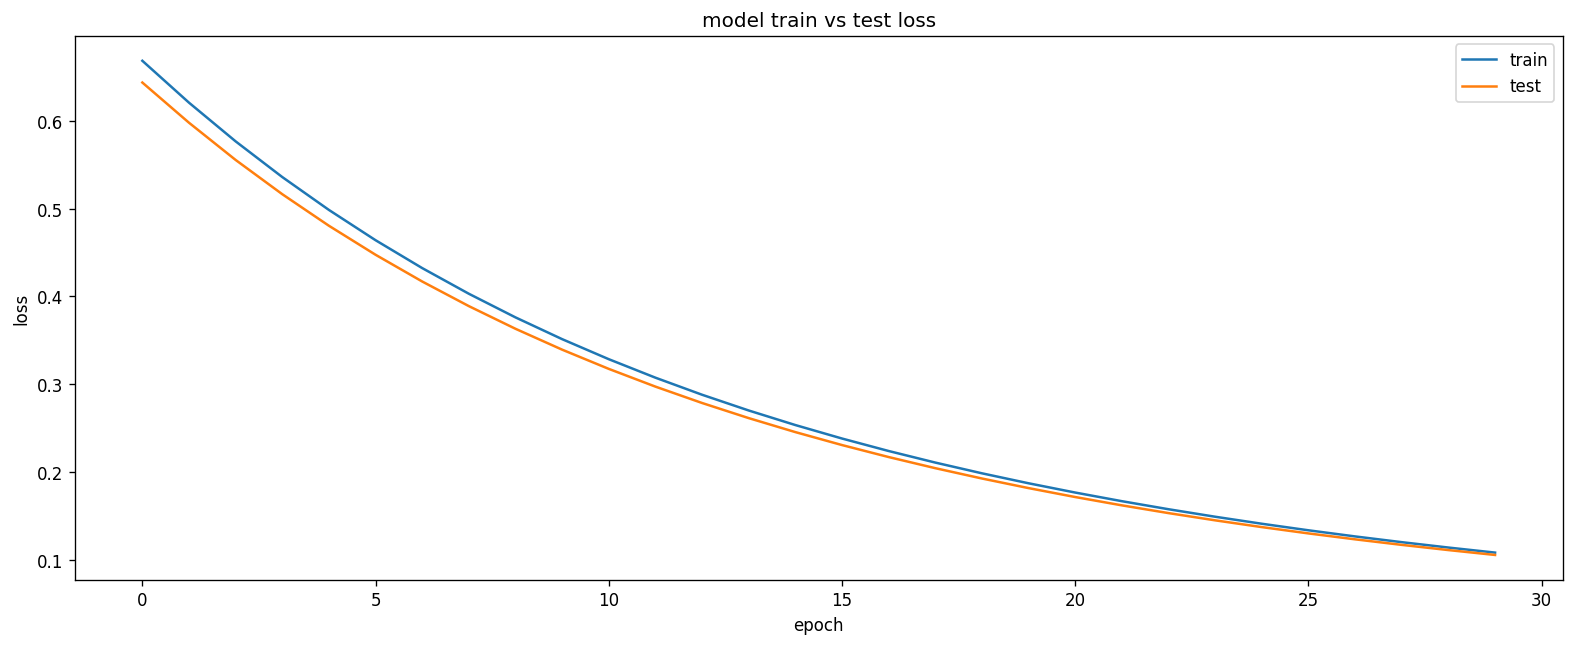

'\n# train one model for/over each of the series\nfor series_index in range(min(3,num)):\n    # keep series name\n    series_name = series_names[series_index, 0]\n\n    # convert input dataset for specific time series to array of series values\n    series_values = dataset.iloc[[series_index], cols].values\n\n    # reshape to column array.  Rows are time series values at specific time points\n    series_values = series_values.reshape(-1,1)\n\n    # execute training, plots\n    execute(series_values, series_names[series_index:], window_length, load_trained_model, series_index, window_length, latent_dimension, epochs,max_encoded_lines_to_print)\n\n'

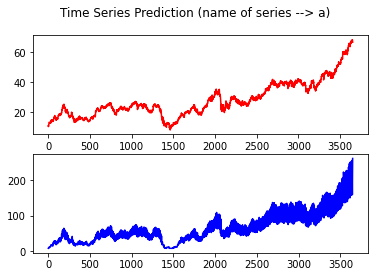

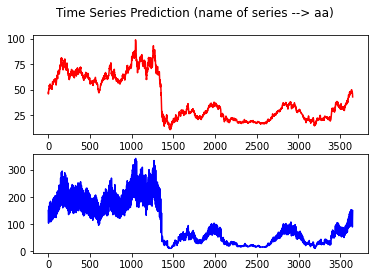

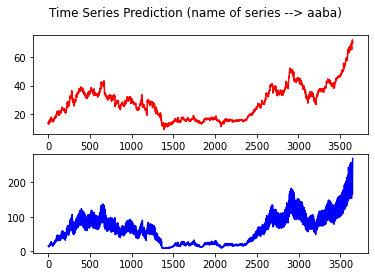

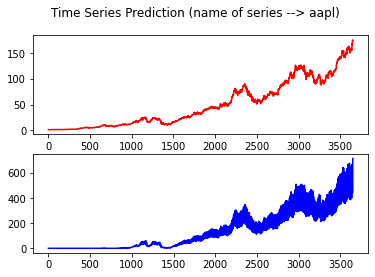

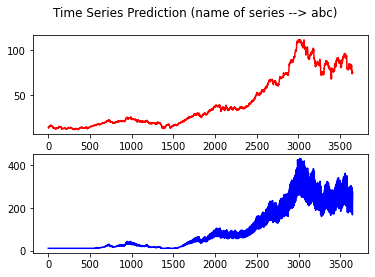

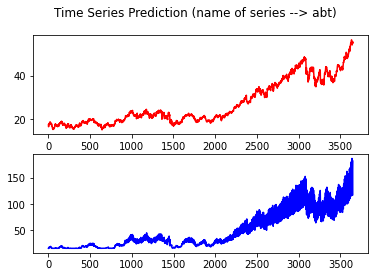

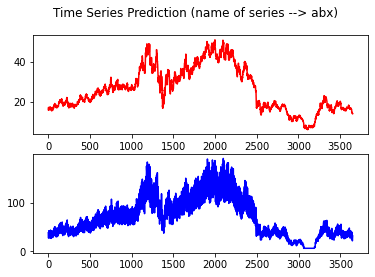

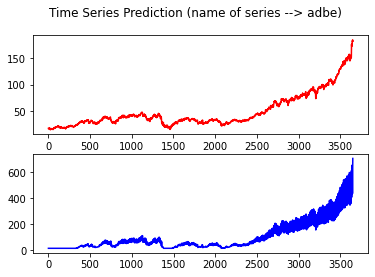

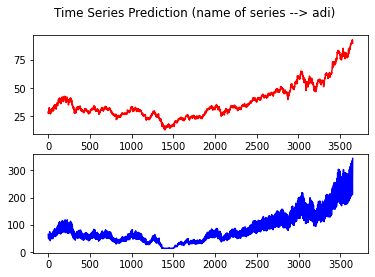

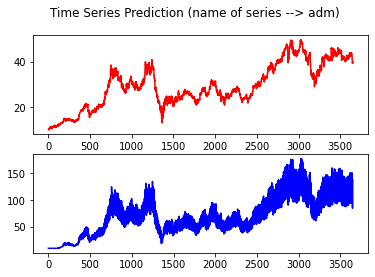

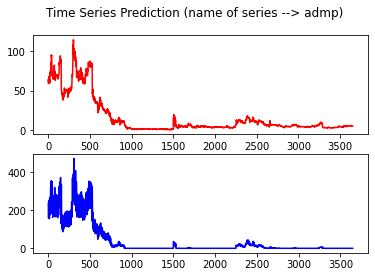

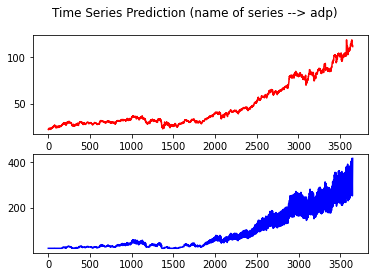

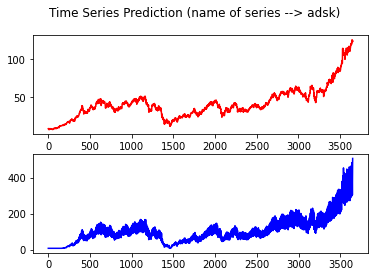

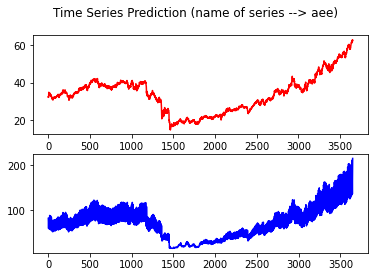

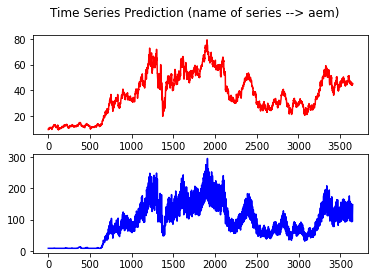

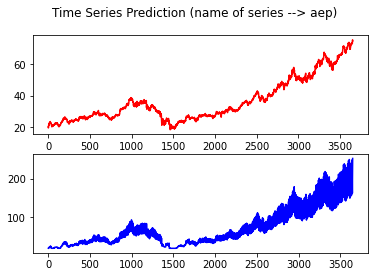

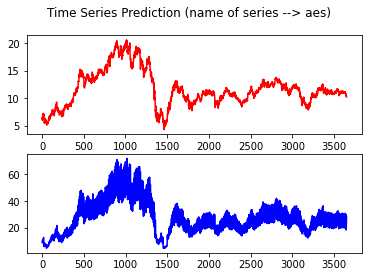

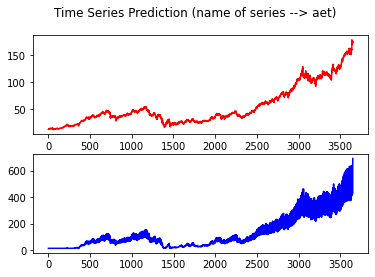

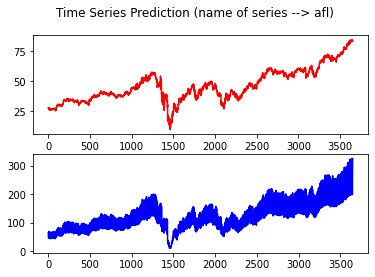

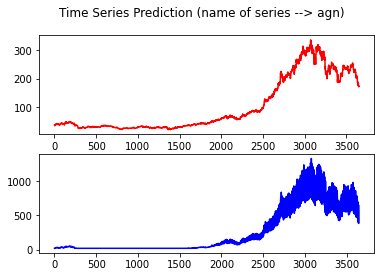

In [81]:
""" file : forecast.py """

""" general imports """
import argparse     # for command line argument parsing
import sys
import string
import os
import random

""" imports for dataframes, numpy """
import pandas as pd
import numpy as np
import math

def reproducibleResults(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

reproducibleResults(6969)

# 6969 (conv1d(8), conv1d(2)) very godd for the whole dataset
# 

# main functionality

# parse command line input


# save arguments
dataset_path = './nasdaq2007_17.csv'
#query_path = args.q
num_of_series = 0
output_dataset_path = './encoded_nasdaq2007_17.csv'
output_query_path = './encoded_nasdaq2007_17.csv'
window_length = 10
latent_dimension = 3
epochs = 30
max_encoded_lines_to_print = 4
# load pre trained model or train new model
load_trained_model = False

# Load and peek the input dataset csv file
dataset = pd.read_csv(dataset_path, sep='\t', lineterminator='\n', header=None)

# keep names of time series in seperate dataframe and convert it to an array
series_names = pd.DataFrame(dataset, columns=[dataset.columns[0]]).values

# specify columns to keep (all but the first one)
cols = [False]
rest_cols= [True for x in range(dataset.shape[1]-1)]
cols.extend(rest_cols)


# If args.n is smaller than 1, then the model will take into account all timeseries in the dataset
if num_of_series < 1:
    num = len(cols)
# otherwise it will only process the first `args.n` time_series
else:
    num = num_of_series

print(num)

# train one model over all series

# convert input dataset for first n time series to array of series values
series_values = dataset.iloc[:num, cols].values

# get transpose to have columns as different time series and rows as time series values at specific time points
series_values = series_values.T
print(series_values.shape)
# execute training, plots
execute(series_values, series_names, window_length, load_trained_model, None, window_length, latent_dimension,epochs,20)

"""
# train one model for/over each of the series
for series_index in range(min(3,num)):
    # keep series name
    series_name = series_names[series_index, 0]

    # convert input dataset for specific time series to array of series values
    series_values = dataset.iloc[[series_index], cols].values

    # reshape to column array.  Rows are time series values at specific time points
    series_values = series_values.reshape(-1,1)

    # execute training, plots
    execute(series_values, series_names[series_index:], window_length, load_trained_model, series_index, window_length, latent_dimension, epochs,max_encoded_lines_to_print)

"""
